In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.window import Window
from pyspark.sql.functions import lag, to_timestamp, col, when, sum, avg, count, split, explode, udf, collect_list, monotonically_increasing_id, row_number, size
from pyspark import Row
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.types import ArrayType, TimestampType
import datetime
from matplotlib import pyplot as plt

In [2]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor, LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

In [3]:
sc = SparkContext.getOrCreate()

In [4]:
spark = SparkSession.builder.getOrCreate()

In [5]:
df = spark.read \
       .format("csv") \
       .option("header", "true") \
       .load("data/user_session_id/*.csv")

In [6]:
df.limit(10).toPandas()

,_c0,_c1,_c2,_c3,_c4,_c5,_c6,_c7,_c8,_c9,...,_c11,_c12,_c13,_c14,user_id,occured_at,last_event,lag_in_day,is_new_session,user_session_id
0,2015-07-22T10:36:50.817943Z,marketpalce-shop,1.186.38.4:58489,10.0.4.217:80,2.2E-5,0.015808,2.1E-5,200,200,0,...,GET https://paytm.com:443/shop?utm_source=Affi...,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_2...,ECDHE-RSA-AES128-GCM-SHA256,TLSv1.2,1.186.38.4,2015-07-22T07:36:50.817-03:00,None,None,0,0
1,2015-07-22T16:21:56.041857Z,marketpalce-shop,1.187.131.255:14811,10.0.4.150:80,2.4E-5,0.003184,2.1E-5,200,200,0,...,GET https://paytm.com:443/shop/g/electronics/c...,Mozilla/5.0 (Linux; Android 5.0; Micromax Q380...,ECDHE-RSA-AES128-GCM-SHA256,TLSv1.2,1.187.131.255,2015-07-22T13:21:56.041-03:00,None,None,0,0
2,2015-07-22T10:49:44.888120Z,marketpalce-shop,1.187.7.103:15975,10.0.6.178:80,2.5E-5,0.071696,2.1E-5,200,200,190,...,POST https://paytm.com:443/ HTTP/1.1,SAMSUNG-GT-C3312/1.0 NetFront/4.2 Profile/MIDP...,AES128-SHA,TLSv1,1.187.7.103,2015-07-22T07:49:44.888-03:00,None,None,0,0
3,2015-07-22T10:49:46.328464Z,marketpalce-shop,1.187.7.103:15975,10.0.6.108:80,2.5E-5,0.002051,2.1E-5,200,200,0,...,GET https://paytm.com:443/styles/app.css HTTP/1.1,SAMSUNG-GT-C3312/1.0 NetFront/4.2 Profile/MIDP...,AES128-SHA,TLSv1,1.187.7.103,2015-07-22T07:49:46.328-03:00,2015-07-22T07:49:44.888-03:00,0.03333333333333333,0,0
4,2015-07-22T06:55:07.710503Z,marketpalce-shop,1.22.132.104:61347,10.0.4.225:80,2.5E-5,0.006085,2.1E-5,200,200,0,...,GET https://paytm.com:443/shop/p/lenovo-yoga-3...,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,ECDHE-RSA-AES128-GCM-SHA256,TLSv1.2,1.22.132.104,2015-07-22T03:55:07.710-03:00,None,None,0,0
5,2015-07-22T06:55:08.919650Z,marketpalce-shop,1.22.132.104:61347,10.0.6.108:80,2.3E-5,0.010206,2.4E-5,200,200,0,...,GET https://paytm.com:443/shop/cart?channel=we...,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,ECDHE-RSA-AES128-GCM-SHA256,TLSv1.2,1.22.132.104,2015-07-22T03:55:08.919-03:00,2015-07-22T03:55:07.710-03:00,0.016666666666666666,0,0
6,2015-07-22T06:55:09.257625Z,marketpalce-shop,1.22.132.104:61347,10.0.6.108:80,2.5E-5,0.004596,2.2E-5,200,200,0,...,GET https://paytm.com:443/papi/nps/merchantrat...,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,ECDHE-RSA-AES128-GCM-SHA256,TLSv1.2,1.22.132.104,2015-07-22T03:55:09.257-03:00,2015-07-22T03:55:08.919-03:00,0.016666666666666666,0,0
7,2015-07-22T06:55:09.278240Z,marketpalce-shop,1.22.132.104:61348,10.0.6.158:80,2.5E-5,0.006642,2.1E-5,200,200,0,...,GET https://paytm.com:443/papi/v1/promosearch/...,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,ECDHE-RSA-AES128-GCM-SHA256,TLSv1.2,1.22.132.104,2015-07-22T03:55:09.278-03:00,2015-07-22T03:55:09.257-03:00,0.0,0,0
8,2015-07-22T06:55:09.338510Z,marketpalce-shop,1.22.132.104:61346,10.0.6.199:80,2.6E-5,0.005262,2.0E-5,200,200,0,...,GET https://paytm.com:443/papi/rr/products/163...,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,ECDHE-RSA-AES128-GCM-SHA256,TLSv1.2,1.22.132.104,2015-07-22T03:55:09.338-03:00,2015-07-22T03:55:09.278-03:00,0.0,0,0
9,2015-07-22T06:55:23.245820Z,marketpalce-shop,1.22.132.104:61346,10.0.4.225:80,2.3E-5,0.004889,2.1E-5,200,200,0,...,GET https://paytm.com:443/shop/p/hp-15-r033tx-...,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,ECDHE-RSA-AES128-GCM-SHA256,TLSv1.2,1.22.132.104,2015-07-22T03:55:23.245-03:00,2015-07-22T03:55:09.338-03:00,0.23333333333333334,0,0


In [7]:
df.dtypes

[('_c0', 'string'),
 ('_c1', 'string'),
 ('_c2', 'string'),
 ('_c3', 'string'),
 ('_c4', 'string'),
 ('_c5', 'string'),
 ('_c6', 'string'),
 ('_c7', 'string'),
 ('_c8', 'string'),
 ('_c9', 'string'),
 ('_c10', 'string'),
 ('_c11', 'string'),
 ('_c12', 'string'),
 ('_c13', 'string'),
 ('_c14', 'string'),
 ('user_id', 'string'),
 ('occured_at', 'string'),
 ('last_event', 'string'),
 ('lag_in_day', 'string'),
 ('is_new_session', 'string'),
 ('user_session_id', 'string')]

## 1. Predict the expected load (requests/second) in the next minute

In [8]:
df.createOrReplaceTempView('user_session_id')

In [9]:
#  user_id|          occured_at|          last_event|user_session_id|          lag_in_day

first_n_last = spark.sql(""" select user_id
                   , user_session_id
                   , to_timestamp(date_format(occured_at, 'yyyy-MM-dd hh:mm')) as first
                   , to_timestamp(date_format(last_event, 'yyyy-MM-dd hh:mm')) as last
              from user_session_id
""")
first_n_last.show()

+-------------+---------------+-------------------+-------------------+
|      user_id|user_session_id|              first|               last|
+-------------+---------------+-------------------+-------------------+
|   1.186.38.4|              0|2015-07-22 07:36:00|               null|
|1.187.131.255|              0|2015-07-22 01:21:00|               null|
|  1.187.7.103|              0|2015-07-22 07:49:00|               null|
|  1.187.7.103|              0|2015-07-22 07:49:00|2015-07-22 07:49:00|
| 1.22.132.104|              0|2015-07-22 03:55:00|               null|
| 1.22.132.104|              0|2015-07-22 03:55:00|2015-07-22 03:55:00|
| 1.22.132.104|              0|2015-07-22 03:55:00|2015-07-22 03:55:00|
| 1.22.132.104|              0|2015-07-22 03:55:00|2015-07-22 03:55:00|
| 1.22.132.104|              0|2015-07-22 03:55:00|2015-07-22 03:55:00|
| 1.22.132.104|              0|2015-07-22 03:55:00|2015-07-22 03:55:00|
| 1.22.132.104|              0|2015-07-22 03:55:00|2015-07-22 03

In [10]:
first_n_last.dtypes

[('user_id', 'string'),
 ('user_session_id', 'string'),
 ('first', 'timestamp'),
 ('last', 'timestamp')]

In [11]:
first_n_last.createOrReplaceTempView('first_n_last')

In [12]:
sessions = spark.sql(""" select user_id
                   , user_session_id
                   , min(first) as first
                   , max(last) as last
              from first_n_last
              group by user_id
                     , user_session_id

""")
sessions.show()

+---------------+---------------+-------------------+-------------------+
|        user_id|user_session_id|              first|               last|
+---------------+---------------+-------------------+-------------------+
| 117.204.165.61|              0|2015-07-22 07:46:00|               null|
|   182.74.51.82|              0|2015-07-22 01:21:00|2015-07-22 01:21:00|
|      1.38.4.10|              4|2015-07-22 03:02:00|2015-07-22 03:02:00|
| 111.93.170.118|              0|2015-07-22 07:35:00|2015-07-22 07:37:00|
|117.217.172.105|              0|2015-07-22 01:13:00|2015-07-22 01:13:00|
| 117.220.67.127|              0|2015-07-22 01:10:00|2015-07-22 01:13:00|
|   122.15.20.34|              3|2015-07-22 07:30:00|2015-07-22 07:49:00|
|  122.163.80.96|              0|2015-07-22 06:01:00|2015-07-22 06:02:00|
|  123.63.153.25|              0|2015-07-22 06:01:00|2015-07-22 06:01:00|
| 182.74.219.150|              1|2015-07-22 01:42:00|2015-07-22 07:32:00|
|  183.82.96.148|              0|2015-

In [13]:
sessions.dtypes

[('user_id', 'string'),
 ('user_session_id', 'string'),
 ('first', 'timestamp'),
 ('last', 'timestamp')]

In [14]:
def list_of_minutes(ts):
    ls = []

    if ts is None:
        return ls


    step = ts
    ls.append(step)

    for i in range(15):
        step += datetime.timedelta(minutes=1)
        ls.append(step)
    
    return ls
list_of_minutes_udf = udf(list_of_minutes, ArrayType(TimestampType()))

In [15]:
def list_to_set(ls1, ls2):
    ls = ls1 + ls2
    return list(set(ls))
list_to_set_udf = udf(list_to_set, ArrayType(TimestampType()))

In [16]:
sessions = sessions.withColumn('first_ls', list_of_minutes_udf(col('first'))) \
                   .withColumn('last_ls', list_of_minutes_udf(col('last'))) \
                   .withColumn('session_minutes', list_to_set_udf(col('first_ls'), col('last_ls')))

In [17]:
sessions.show()

+---------------+---------------+-------------------+-------------------+--------------------+--------------------+--------------------+
|        user_id|user_session_id|              first|               last|            first_ls|             last_ls|     session_minutes|
+---------------+---------------+-------------------+-------------------+--------------------+--------------------+--------------------+
| 117.204.165.61|              0|2015-07-22 07:46:00|               null|[2015-07-22 07:46...|                  []|[2015-07-22 07:56...|
|   182.74.51.82|              0|2015-07-22 01:21:00|2015-07-22 01:21:00|[2015-07-22 01:21...|[2015-07-22 01:21...|[2015-07-22 01:22...|
|      1.38.4.10|              4|2015-07-22 03:02:00|2015-07-22 03:02:00|[2015-07-22 03:02...|[2015-07-22 03:02...|[2015-07-22 03:03...|
| 111.93.170.118|              0|2015-07-22 07:35:00|2015-07-22 07:37:00|[2015-07-22 07:35...|[2015-07-22 07:37...|[2015-07-22 07:36...|
|117.217.172.105|              0|2015-07-

In [18]:
sessions = sessions.withColumn('minutes', size(col('session_minutes')))

In [19]:
sessions.select('user_id', 'user_session_id', 'minutes').write.csv('data/sessions', header=True)

In [20]:
session_minutes = sessions.withColumn('ts', explode(col('session_minutes'))) \
                                 .groupby('ts') \
                                 .agg(count('ts').alias('n_users')) \
                                 .orderBy('ts')
session_minutes.show()

+-------------------+-------+
|                 ts|n_users|
+-------------------+-------+
|2015-07-21 11:40:00|    777|
|2015-07-21 11:41:00|   1291|
|2015-07-21 11:42:00|   1757|
|2015-07-21 11:43:00|   2246|
|2015-07-21 11:44:00|   2738|
|2015-07-21 11:45:00|   2801|
|2015-07-21 11:46:00|   2801|
|2015-07-21 11:47:00|   2801|
|2015-07-21 11:48:00|   2801|
|2015-07-21 11:49:00|   2801|
|2015-07-21 11:50:00|   2801|
|2015-07-21 11:51:00|   2801|
|2015-07-21 11:52:00|   2801|
|2015-07-21 11:53:00|   2801|
|2015-07-21 11:54:00|   2801|
|2015-07-21 11:55:00|   2801|
|2015-07-21 11:56:00|   2336|
|2015-07-21 11:57:00|   1893|
|2015-07-21 11:58:00|   1406|
|2015-07-21 11:59:00|    882|
+-------------------+-------+
only showing top 20 rows



In [21]:
session_minutes.createOrReplaceTempView('session_minutes')

In [22]:
row = spark.sql("select min(ts) as start, max(ts) as end from session_minutes").collect()[0]
start = row.start
end = row.end

In [23]:
start

datetime.datetime(2015, 7, 21, 11, 40)

In [24]:
end

datetime.datetime(2015, 7, 22, 13, 10)

In [25]:
ls = [start]

In [26]:
step = start
while step < end:
    step += datetime.timedelta(minutes=1)
    ls.append(step)

In [27]:
timespan = spark.createDataFrame(list(map(lambda x: Row(ts=x), ls)))
timespan.show()

+-------------------+
|                 ts|
+-------------------+
|2015-07-21 11:40:00|
|2015-07-21 11:41:00|
|2015-07-21 11:42:00|
|2015-07-21 11:43:00|
|2015-07-21 11:44:00|
|2015-07-21 11:45:00|
|2015-07-21 11:46:00|
|2015-07-21 11:47:00|
|2015-07-21 11:48:00|
|2015-07-21 11:49:00|
|2015-07-21 11:50:00|
|2015-07-21 11:51:00|
|2015-07-21 11:52:00|
|2015-07-21 11:53:00|
|2015-07-21 11:54:00|
|2015-07-21 11:55:00|
|2015-07-21 11:56:00|
|2015-07-21 11:57:00|
|2015-07-21 11:58:00|
|2015-07-21 11:59:00|
+-------------------+
only showing top 20 rows



In [28]:
timespan.dtypes

[('ts', 'timestamp')]

In [29]:
timespan.createOrReplaceTempView('timespan')

In [30]:
timeseries = spark.sql(""" 
select a.ts
     , coalesce(n_users, 0) as n_users
from timespan a left outer join session_minutes b on a.ts = b.ts
order by ts
""")
timeseries.show()

+-------------------+-------+
|                 ts|n_users|
+-------------------+-------+
|2015-07-21 11:40:00|    777|
|2015-07-21 11:41:00|   1291|
|2015-07-21 11:42:00|   1757|
|2015-07-21 11:43:00|   2246|
|2015-07-21 11:44:00|   2738|
|2015-07-21 11:45:00|   2801|
|2015-07-21 11:46:00|   2801|
|2015-07-21 11:47:00|   2801|
|2015-07-21 11:48:00|   2801|
|2015-07-21 11:49:00|   2801|
|2015-07-21 11:50:00|   2801|
|2015-07-21 11:51:00|   2801|
|2015-07-21 11:52:00|   2801|
|2015-07-21 11:53:00|   2801|
|2015-07-21 11:54:00|   2801|
|2015-07-21 11:55:00|   2801|
|2015-07-21 11:56:00|   2336|
|2015-07-21 11:57:00|   1893|
|2015-07-21 11:58:00|   1406|
|2015-07-21 11:59:00|    882|
+-------------------+-------+
only showing top 20 rows



In [31]:
timeseries.count()

1531

In [32]:
n_users = [row.n_users for row in timeseries.collect()]

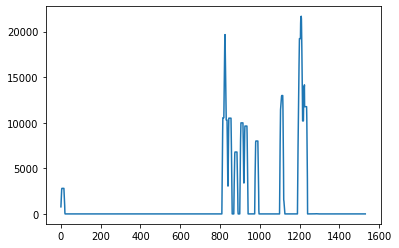

In [33]:
plt.plot(n_users);

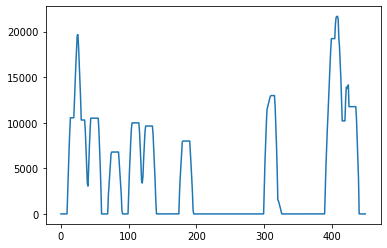

In [34]:
plt.plot(n_users[800:1250]);

In [35]:
partial = n_users[800:1250]

In [36]:
ls = []
step = 0
offset = 10
while step + offset < len(partial):
    slide = partial[step:step + offset]
    step += 1
    ls.append(slide)

In [37]:
len(ls)

440

In [38]:
ls[0:10]

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 2425],
 [0, 0, 0, 0, 0, 0, 0, 1, 2425, 4990],
 [0, 0, 0, 0, 0, 0, 1, 2425, 4990, 6982],
 [0, 0, 0, 0, 0, 1, 2425, 4990, 6982, 8948],
 [0, 0, 0, 0, 1, 2425, 4990, 6982, 8948, 10541],
 [0, 0, 0, 1, 2425, 4990, 6982, 8948, 10541, 10541],
 [0, 0, 1, 2425, 4990, 6982, 8948, 10541, 10541, 10541],
 [0, 1, 2425, 4990, 6982, 8948, 10541, 10541, 10541, 10541],
 [1, 2425, 4990, 6982, 8948, 10541, 10541, 10541, 10541, 10541]]

In [39]:
ls[-1]

[3864, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [40]:
tsw = spark.createDataFrame(list(map(lambda x: Row(features=Vectors.dense(x[:-1]), label=x[-1]), ls)))
tsw.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.0,0.0,0.0,0.0,...|    1|
|[0.0,0.0,0.0,0.0,...| 2425|
|[0.0,0.0,0.0,0.0,...| 4990|
|[0.0,0.0,0.0,0.0,...| 6982|
|[0.0,0.0,0.0,0.0,...| 8948|
|[0.0,0.0,0.0,0.0,...|10541|
|[0.0,0.0,0.0,1.0,...|10541|
|[0.0,0.0,1.0,2425...|10541|
|[0.0,1.0,2425.0,4...|10541|
|[1.0,2425.0,4990....|10541|
|[2425.0,4990.0,69...|10542|
|[4990.0,6982.0,89...|12487|
|[6982.0,8948.0,10...|14613|
|[8948.0,10541.0,1...|16333|
|[10541.0,10541.0,...|17884|
|[10541.0,10541.0,...|19528|
|[10541.0,10541.0,...|19667|
|[10541.0,10541.0,...|18398|
|[10541.0,10542.0,...|16529|
|[10542.0,12487.0,...|14748|
+--------------------+-----+
only showing top 20 rows



In [41]:
tsw.dtypes

[('features', 'vector'), ('label', 'bigint')]

In [42]:
tsw.select('features').first()

Row(features=DenseVector([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]))

In [43]:
tsw = tsw.withColumn('seq', monotonically_increasing_id())
tsw = tsw.withColumn("index", row_number().over(Window.orderBy("seq")))
tsw.show()

+--------------------+-----+---+-----+
|            features|label|seq|index|
+--------------------+-----+---+-----+
|[0.0,0.0,0.0,0.0,...|    1|  0|    1|
|[0.0,0.0,0.0,0.0,...| 2425|  1|    2|
|[0.0,0.0,0.0,0.0,...| 4990|  2|    3|
|[0.0,0.0,0.0,0.0,...| 6982|  3|    4|
|[0.0,0.0,0.0,0.0,...| 8948|  4|    5|
|[0.0,0.0,0.0,0.0,...|10541|  5|    6|
|[0.0,0.0,0.0,1.0,...|10541|  6|    7|
|[0.0,0.0,1.0,2425...|10541|  7|    8|
|[0.0,1.0,2425.0,4...|10541|  8|    9|
|[1.0,2425.0,4990....|10541|  9|   10|
|[2425.0,4990.0,69...|10542| 10|   11|
|[4990.0,6982.0,89...|12487| 11|   12|
|[6982.0,8948.0,10...|14613| 12|   13|
|[8948.0,10541.0,1...|16333| 13|   14|
|[10541.0,10541.0,...|17884| 14|   15|
|[10541.0,10541.0,...|19528| 15|   16|
|[10541.0,10541.0,...|19667| 16|   17|
|[10541.0,10541.0,...|18398| 17|   18|
|[10541.0,10542.0,...|16529| 18|   19|
|[10542.0,12487.0,...|14748| 19|   20|
+--------------------+-----+---+-----+
only showing top 20 rows



In [44]:
tsw.count()

440

In [45]:
tsw.dtypes

[('features', 'vector'),
 ('label', 'bigint'),
 ('seq', 'bigint'),
 ('index', 'int')]

In [46]:
train = tsw.where('index <= 340')
test = tsw.where('index > 340')

In [47]:
train.count(), test.count()

(340, 100)

In [48]:
rf = RandomForestRegressor(featuresCol="features")
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [5, 10, 20]) \
    .build()

evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")    

crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  

model = crossval.fit(train)               

predictions = model.transform(test)

rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
print(model.bestModel)

Root Mean Squared Error (RMSE) on test data = 2460.98
RandomForestRegressionModel: uid=RandomForestRegressor_5a3e332193c1, numTrees=10, numFeatures=9


In [49]:
results = predictions.select('label', 'prediction').toPandas()
results

,label,prediction
0,0,66.869787
1,0,66.869787
2,0,66.869787
3,0,66.869787
4,0,66.869787
...,...,...
95,0,67.926004
96,0,1.610594
97,0,4.956699
98,0,19.996733


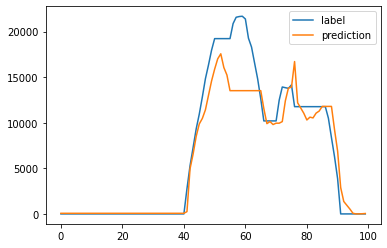

In [50]:
plt.plot(results.index, results.label)
plt.plot(results.index, results.prediction)
plt.legend(['label', 'prediction'])
plt.show()

In [51]:
spark.stop()